In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
from zipfile import ZipFile
from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import column_or_1d
# import sklearn


#### Here we are focusing on agricultural pollution and industrial residue in the Baltic Sea

A significant problem in the Baltic sea is eutrophication which leads to cloudy water, reducing light conditions in the water and oxygen consumption. The excessive richness of nutrition in water is caused mainly by agricultural pollution and industrial residue. 

|  element  | short-form |
|  ----  | ----  |
|Dissolved oxygen |  OXY|
|Phosphate | PO4|
|Total phosphorus | TP|
|Nitrogen dioxide | NO2|
|Nitrate | NO3|
|Ammonia | NH4|
|Total nitrogen | TN|
|Silicon dioxide | SIO2|
|Chlorophyll | CHLORA|
|Secchi depth | SECCHI|
|Dissolved Inorganic Carbon (DIC) | PH|
|Salinity | CTDSAL|
|Centigrade Temperature | CTDTMP|

In [ ]:
!pip install -q gdown httpimport
!gdown 'https://github.com/wenjie-hoo/baltic_ml/raw/main/2022.11.07-merged-single-observation.zip'

In [110]:
# load data to data frame
zip_file = ZipFile('./2022.11.07-merged-single-observation.zip')
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv') and not text_file.filename[37:].startswith('.')}

df_list=[]
for df in dfs.values():
       df['DATE'] = pd.to_datetime(df['DATE'],dayfirst = True)
       df_list.append(df)

df = reduce(lambda left,right: pd.merge(left.drop_duplicates(subset=['DATE','DEPTH']),right.drop_duplicates(subset=['DATE','DEPTH']),on=['DATE','DEPTH'],how='outer'), df_list)
# df.to_csv('xxxxx.csv')

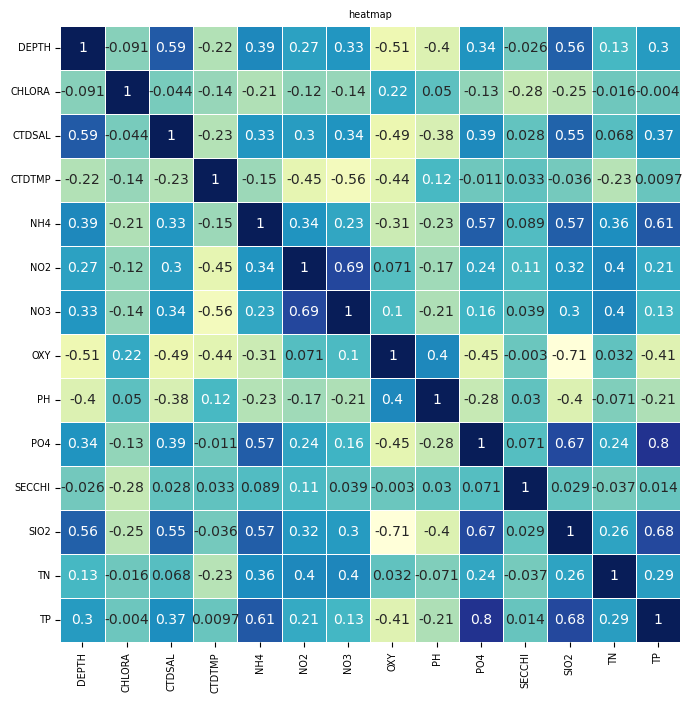

In [111]:

fig = plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),vmax=1, annot=True, linewidths=0.5, cbar=False, cmap='YlGnBu',annot_kws={'fontsize':10})
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('heatmap',fontsize=7)
plt.show()

In [76]:
# check missing values
df_missing = df.drop(['DATE'],axis=1)
missing = df_missing.isna().sum()
missing = pd.DataFrame(data={'elements': missing.index,'missing':missing.values})
missing = missing[~missing['missing'].isin([0])]
missing['percentage'] =  missing['missing']/df_missing.shape[0]
missing.sort_values(by='percentage',ascending=False)


,elements,missing,percentage
8,PH,4011,0.841233
12,TN,2167,0.454488
5,NO2,2062,0.432466
4,NH4,1998,0.419044
11,SIO2,1920,0.402685
6,NO3,1886,0.395554
10,SECCHI,1796,0.376678
1,CHLORA,1773,0.371854
9,PO4,1202,0.252097
13,TP,801,0.167995


In [112]:
# check df data type
df_missing[missing['elements']].info()
df_missing = df_missing.drop(['DEPTH'],axis=1)
df_missing = df_missing.drop(['PH'],axis=1) # PH has too many missing values


KeyError: "['PH'] not in index"

In [78]:
X_missing = df_missing.copy()
y_missing = df_missing.copy()
y_missing.dropna(inplace=True) 
X_missing = pd.DataFrame(X_missing)
y_missing = pd.DataFrame(y_missing)

In [113]:
# fill missing values with random forest regression 
X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values #sort missing columns

for i in sortindex:
    df_ = X_missing_reg  
    fillc = df_.iloc[:, i]  
    df_ = pd.concat([df_.drop(df_.columns[i], axis=1), pd.DataFrame(y_missing)], axis=1)
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df_)
    #train and test dataset
    Ytrain = fillc[fillc.notnull()]  # not missing part is Y_train
    Ytest = fillc[fillc.isnull()] 
    Xtrain = df_0[Ytrain.index, :]
    Xtest = df_0[Ytest.index, :] 
    rfc = RandomForestRegressor(n_estimators=100) 
    rfc = rfc.fit(Xtrain, Ytrain)  
    Ypredict = rfc.predict(Xtest)
    # put prediction values back to df
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), X_missing_reg.columns[i]] = Ypredict

X_missing_reg.isna().sum()


In [114]:
X_missing_reg.insert(0,column = 'DATE',value=df['DATE'])
X_missing_reg.insert(1,column = 'DEPTH',value=df['DEPTH'])


In [122]:
# print(df['DEPTH'].value_counts())
depth_list = (df['DEPTH'].value_counts()[df['DEPTH'].value_counts() > 400]).index.to_list()
depth_list.sort()
print(depth_list)

[100, 500, 1000, 1500, 2000, 2500]


In [123]:
# create df by depth
def filter_by_depth(df, depth):
    df = df.loc[df['DEPTH'] == depth]
    return df

df_depth_list = []
for i in depth_list:
    df_name = 'df_depth_' + str(i)
    vars()[df_name] = filter_by_depth(X_missing_reg,i)
    df_depth_list.append(df_name)
df_depth_list

['df_depth_100',
 'df_depth_500',
 'df_depth_1000',
 'df_depth_1500',
 'df_depth_2000',
 'df_depth_2500']

### Examples of physical and chemical water quality indicators include:
nutrients (e.g. nitrogen, phosphorus) \
microalgal growth (e.g. chlorophyll-a) \
water clarity (e.g. turbidity, suspended solids, Secchi depth)\
pH\
dissolved oxygen\
temperature\
salinity\
metals (e.g. lead, copper)\
pesticides.

In [ ]:
# use raw data
# df = df.drop(['PH'],axis=1)
# df.dropna(inplace=True)
# df.shape

In [ ]:
# use filled data
# df = pd.DataFrame(X_missing_reg)
# df.shape

In [ ]:
# use filled data by depth
# df = pd.DataFrame(df_depth_100)
# df = pd.DataFrame(df_depth_500)
# df = pd.DataFrame(df_depth_1000)
# df = pd.DataFrame(df_depth_1500)
# df = pd.DataFrame(df_depth_2000)
# df = pd.DataFrame(df_depth_2500)
df.shape

#### Created simple parameter : 0.4*OXY + 0.3*SECCHI + 0.3*CHLORA measuring water quality and tried predicting it on models provided at models.ipynb with some small modifications, using elements from fertilizers and silicate as X
#### works ok mostly based on silicates,  but other matters too r2_score better at greater depths

In [ ]:
def get_splitted_dataset(df):
    X_cols = ['TP', 'TN', 'NO3','PO4', 'NH4', 'SIO2','CTDTMP','CTDSAL']
    df['quality'] = 0.4*df['OXY'] + 0.3*df['SECCHI'] + 0.3*df['CHLORA']
    y_col = ['quality']
    X = df[X_cols]
    y = df[y_col]
    y = column_or_1d(y, warn=True)  
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return x_train, x_test, y_train, y_test

# X_cols = ['TP', 'TN', 'NO3','PO4', 'NH4', 'SIO2','CTDTMP','CTDSAL']
# df['quality'] = 0.4*df['OXY'] + 0.3*df['SECCHI'] + 0.3*df['CHLORA']
# y_col = ['quality']
# X = df[X_cols]
# y = df[y_col]
# y = column_or_1d(y, warn=True)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true  ) ) ) * 100

In [ ]:
x_train, x_test, y_train, y_test = get_splitted_dataset(df_depth_100)

In [ ]:
# linear regression
lg = LinearRegression()
lg.fit(x_train, y_train)
y_pred_lr = lg.predict(x_test)
print('MSE:',mean_squared_error(y_test,y_pred_lr))
print('MAE:',mean_absolute_error(y_test,y_pred_lr))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_lr))

In [ ]:
# Gradient boosting regression
bg = GradientBoostingRegressor()
bg.fit(x_train, y_train)
y_pred_gbr = bg.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_gbr))
print('MAE:',mean_absolute_error(y_test,y_pred_gbr))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_gbr))


In [ ]:
# neural network
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(2,2), solver='sgd', max_iter=3000)
mlp.fit(x_train,y_train)
y_pred_mlp = mlp.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_mlp))
print('MAE:',mean_absolute_error(y_test,y_pred_mlp))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_mlp))


In [85]:
# random forest 
rfr = RandomForestRegressor(random_state=0)
rfr.fit(x_train, y_train)
y_pred_rf = rfr.predict(x_test)
print('MSE:',mean_squared_error(y_test, y_pred_rf))
print('MAE:',mean_absolute_error(y_test,y_pred_rf))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred_rf))


def rfr_pre(x_train,x_test,y_train,y_test):
    rfr = RandomForestRegressor(random_state=0)
    rfr.fit(x_train, y_train)
    y_pred_rf = rfr.predict(x_test)
    return y_pred_rf

MSE: 457.6656578130435
MAE: 15.800725337168174
MAPE: 40.173026629532885


In [ ]:
def plot_feature(df,x_train):
    feat_lebels = x_train.columns[0:]
    importances  = rfr.feature_importances_
    indices = np.argsort(importances)[::-1]
    index_list = []
    value_list = []
    for i,j in zip(range(x_train.shape[1]-1),indices):
        index_list.append(feat_lebels[j])
        value_list.append(importances[j])
        # print(i+1, feat_lebels[j], importances[j])

    plt.figure(figsize=(4,3))
    plt.barh(index_list[::-1],value_list[::-1])
    plt.yticks(fontsize = 12)
    plt.title(df+' '+'feature',fontsize = 10)
    plt.show()


# feat_lebels = x_train.columns[0:]
# importances  = rfr.feature_importances_
# indices = np.argsort(importances)[::-1]
# index_list = []
# value_list = []
# for i,j in zip(range(x_train.shape[1]-1),indices):
#     index_list.append(feat_lebels[j])
#     value_list.append(importances[j])
#     print(i+1, feat_lebels[j], importances[j])

# plt.figure(figsize=(4,3))
# plt.barh(index_list[::-1],value_list[::-1])
# plt.yticks(fontsize = 12)
# plt.title('feature',fontsize = 14)
# plt.show()

In [ ]:
# find best parameters
def get_best_param(x_train, y_train):
    param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]}
    grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
    grid_seach_rf.fit(x_train, y_train)
    best = grid_seach_rf.best_params_
    return best


param_grid = {
    'n_estimators':[50,75,100],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3]
}
grid_seach_rf= GridSearchCV(estimator=RandomForestRegressor(random_state=0),param_grid=param_grid, scoring='neg_mean_squared_error', cv = 5)
grid_seach_rf.fit(x_train, y_train)
best = grid_seach_rf.best_params_
# print(best)

In [ ]:
# prediction model
def rfr_prediction(x_train,x_test,y_train,y_test,best_param):
    rfr_ = RandomForestRegressor(n_estimators=best_param['n_estimators'], 
    min_samples_leaf=best_param['min_samples_leaf'], min_samples_split=best_param['min_samples_split'],
    random_state=0)
    
    rfr_.fit(x_train, y_train)
    y_pred = rfr_.predict(x_test)
    # print(mean_squared_error(y_test, y_pred))
    # print(mean_absolute_percentage_error(y_test, y_pred))    
    
    return y_pred
    
rfr_ = RandomForestRegressor(n_estimators=best['n_estimators'], 
    min_samples_leaf=best['min_samples_leaf'], min_samples_split=best['min_samples_split'],
    random_state=0)
rfr_.fit(x_train, y_train)
y_pred = rfr_.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
# error score
def error_score(y_test,y_pred):
    print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  
    errors = abs(y_pred - y_test)
    print('Mean Absolute Error:{}'.format(np.round(np.mean(errors), 2)), 'degrees.')
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:{}'.format(round(accuracy, 2)), '%.')    
    return accuracy

print('sklearn score:{}'.format(r2_score(y_test, y_pred)))  
errors = abs(y_pred - y_test)
print('Mean Absolute Error:{}'.format(np.round(np.mean(errors), 2)), 'degrees.')
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:{}'.format(round(accuracy, 2)), '%.')

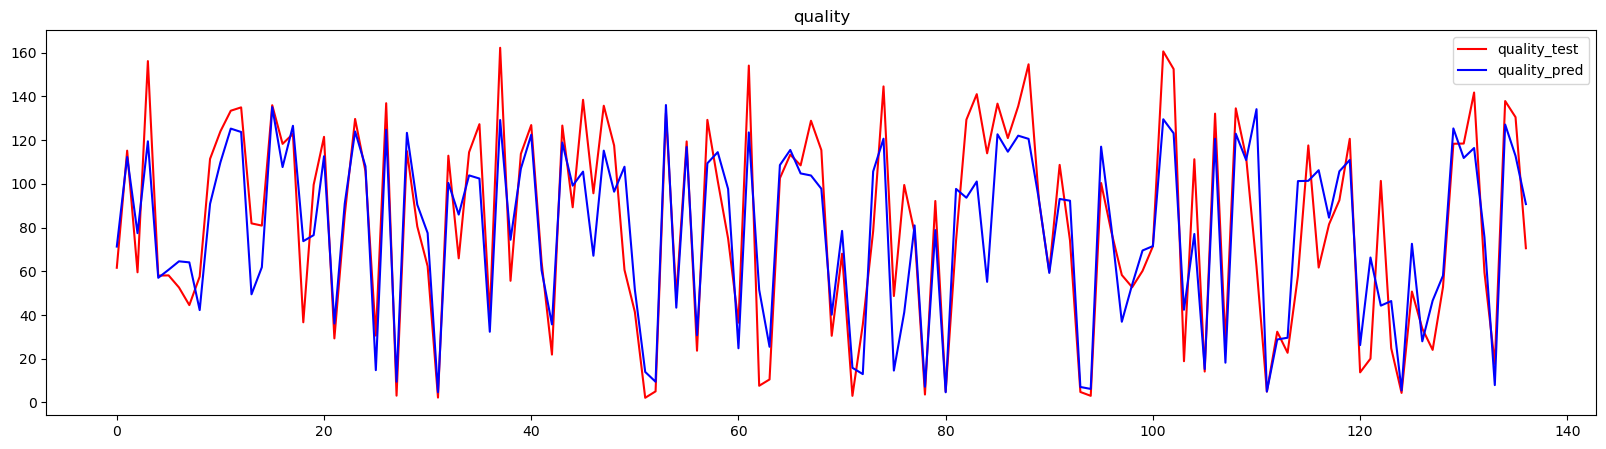

In [136]:
plt.figure(figsize=(20, 5))
plt.plot(y_test, color='red', label='quality_test')
plt.plot(y_pred, color='blue', label='quality_pred')
plt.legend(loc="upper right")
plt.title("quality")
plt.show()


In [143]:
def display_qualify(df_ , y_test, y_pred):
    plt.figure(figsize=(20, 5))
    plt.plot(y_test, color='red', label='quality_test')
    plt.plot(y_pred, color='blue', label='quality_pred')
    plt.legend(loc="upper right")
    plt.title( df_ +" water quality")
    plt.show()


df_depth_100
92.03812800155427
5.051414039786517
sklearn score:0.7992399840892698
Mean Absolute Error:6.51 degrees.
Accuracy:94.95 %.


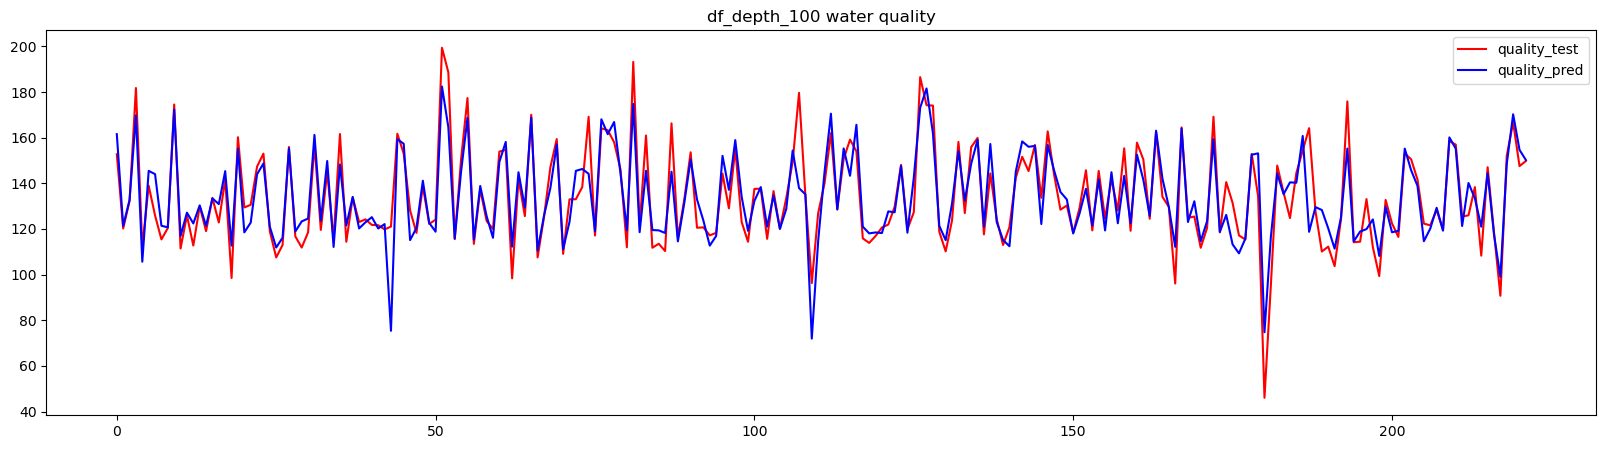

 
df_depth_500
150.53002380995753
7.789490968303844
sklearn score:0.730966264156226
Mean Absolute Error:7.19 degrees.
Accuracy:92.21 %.


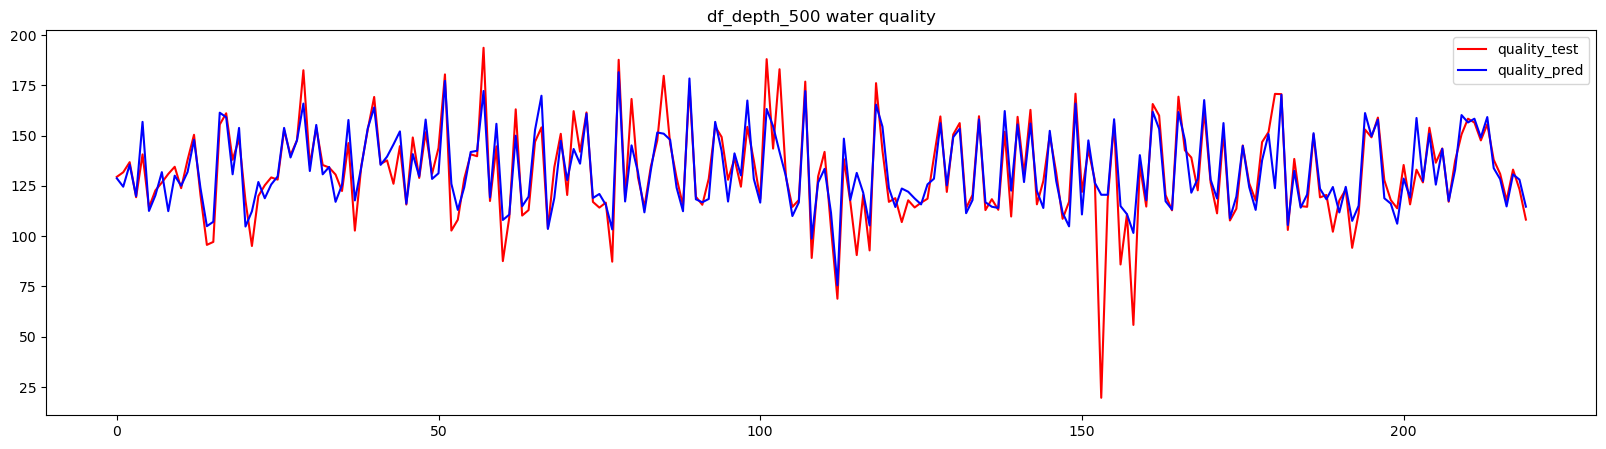

 
df_depth_1000
168.58376368641484
8.291402851569785
sklearn score:0.7747391217467913
Mean Absolute Error:9.02 degrees.
Accuracy:91.71 %.


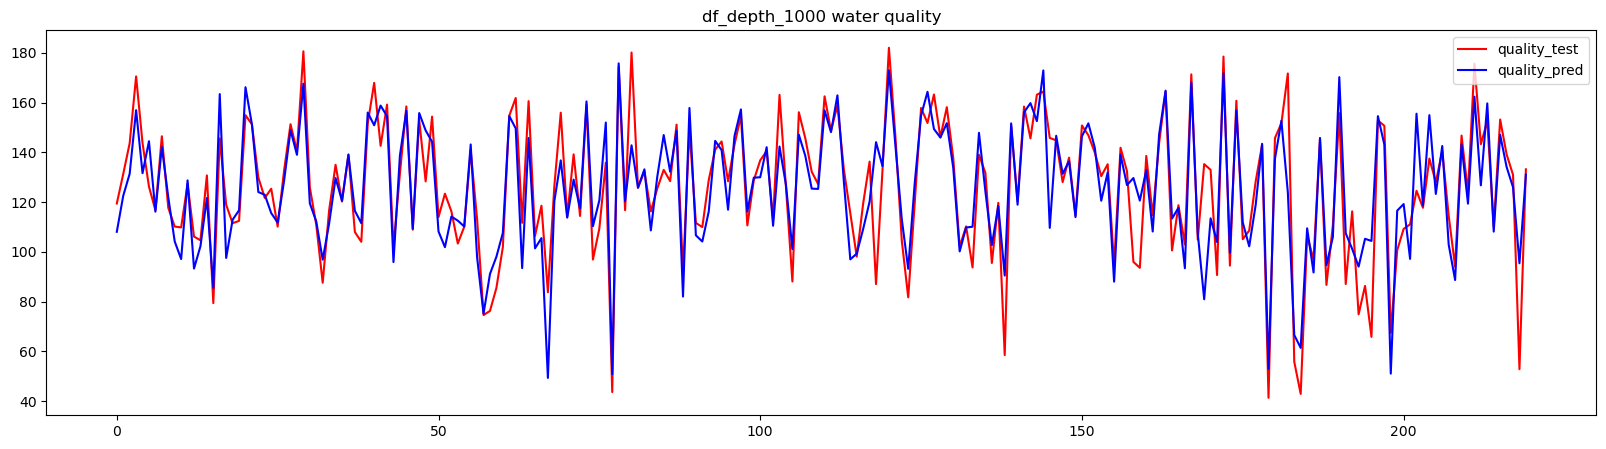

 
df_depth_1500
219.4982721580676
11.958846045634475
sklearn score:0.8122403361967347
Mean Absolute Error:10.5 degrees.
Accuracy:88.04 %.


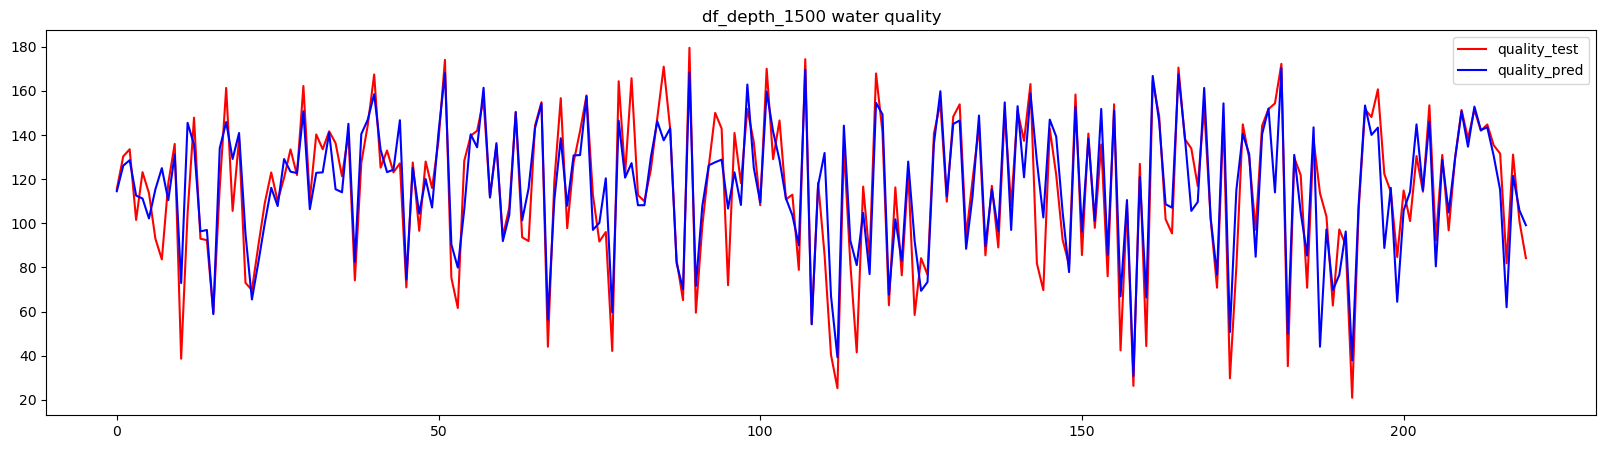

 
df_depth_2000
357.228768189739
23.374031882099448
sklearn score:0.8079648316017067
Mean Absolute Error:13.38 degrees.
Accuracy:76.63 %.


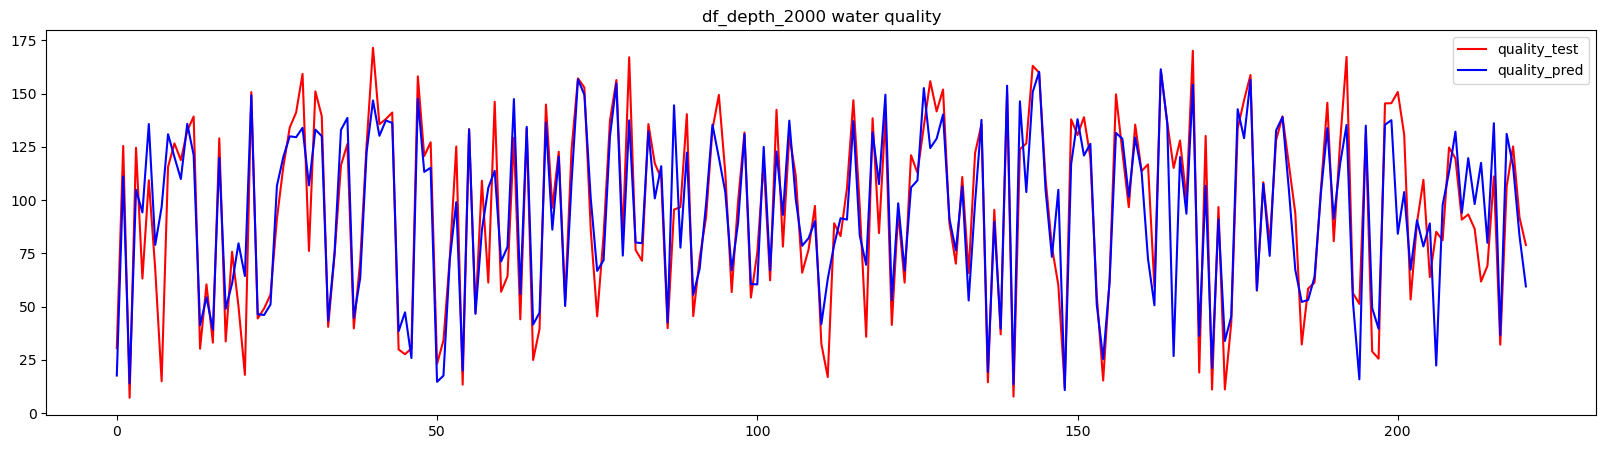

 
df_depth_2500
457.63715502745754
41.59110296913637
sklearn score:0.7802904552694594
Mean Absolute Error:16.32 degrees.
Accuracy:58.41 %.


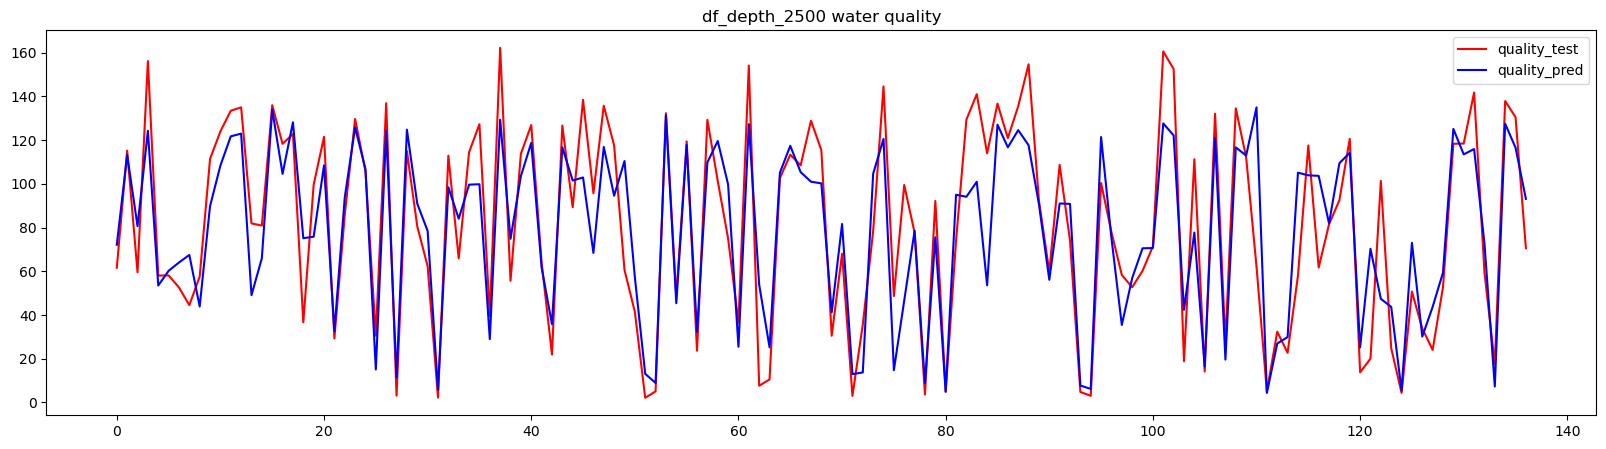

In [147]:
acc_list = []
for df_ in df_depth_list:
    print(df_)
    # df_ = vars()[df_]
    x_train, x_test, y_train, y_test = get_splitted_dataset(vars()[df_])
    # plot_feature(df,x_train)
    best_param = get_best_param(x_train,y_train)
    y_pred = rfr_prediction(x_train,x_test,y_train,y_test,best_param)
    # y_pred = rfr_pre(x_train,x_test,y_train,y_test)
    accuracy = error_score(y_test,y_pred)
    acc_list.append(accuracy)
    display_qualify(df_, y_test, y_pred)
    print(' ')

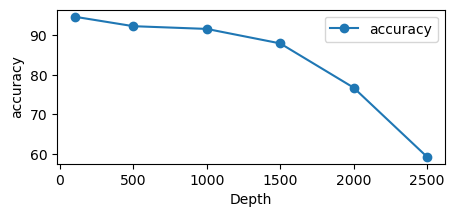

In [146]:
plt.figure(figsize=(5,2))
plt.plot([depth for depth in depth_list],[acc for acc in acc_list],'o-',label="accuracy")#o-:圆形
plt.xlabel("Depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()
